# Combinatorial library analysis

## Aim of this notebook

In this notebook we want to analyze the combinatorial library, TBA.

1. Combinatorial library data
2. Recombined ligand size
3. Lipinski's rule of five
4. Original ligands
5. ChEMBL ligands

In [1]:
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
PATH_COMBINATORIAL_LIBRARY = Path('../data/combinatorial_library/combinatorial_library.json')

## 1. Combinatorial library data

The combinatorial library comes as large JSON file. In order to access/filter ligands efficiently (time and memory), we use the `ijson` library:

> Ijson is an iterative JSON parser with standard Python iterator interfaces.

https://pypi.org/project/ijson/

Here, we take a look at the first entry in the combinatorial library:

In [3]:
# open file
f = open(PATH_COMBINATORIAL_LIBRARY, 'rb')

# yield native Python objects out of a JSON stream located under a prefix
objects = ijson.items(f, 'item')

next(objects)

{'bond_ids': [['SE_13', 'AP_7']],
 'fragment_ids': ['SE_4', 'AP_2'],
 'hba': 1,
 'hbd': 1,
 'mwt': 1,
 'logp': 1,
 'n_atoms': 20,
 'chembl_exact': [],
 'chembl_most_similar': ['CHEMBL405398', Decimal('0.35')],
 'original_exact': [],
 'original_substructure': [],
 'inchi': 'InChI=1S/C15H21N5/c1-12-11-15(18-17-12)16-13-3-5-14(6-4-13)20-9-7-19(2)8-10-20/h3-6,11H,7-10H2,1-2H3,(H2,16,17,18)'}

The combinatorial library contains the following information:
- `bond_ids` and `fragment_ids`: 
  - Bond IDs (`bond_ids`), e.g. `[["FP_6", "AP_10"], ["AP_11", "SE_13"]]`: Atom (`<subpocket>_<atom ID>`) pairs per fragment bond
  - Fragment IDs (`fragment_ids`), e.g. `["SE_2", "AP_0", "FP_2"]` (`<subpocket>_<fragment index in subpocket pool>`)
  - With this information it is possible to construct the recombined ligand from the fragment library
- `hba`, `hbd`, `mwt`, and `logp`: Ligand fulfills Lipinski's rule of five criteria? (`0` or `1`)
  - Number of hydrogen bond acceptors (`hba`) <= 10
  - Number of hydrogen bond donors (`hbd`) <= 5
  - Molecular weight (`mwt`) <= 500
  - LogP value (`logp`) <= 5 
- `n_atoms`: Number of heavy atoms
- `chembl_exact`: Ligand has exact match in ChEMBL? List of ChEMBL molecule indicies (`[]` if no match)
- `chembl_most_similar`: Most similar molecule in ChEMBL, e.g. `[500021, 0.34]` (`[<ChEMBL ID without "CHEMBL" prefix>, <Tanimoto similarity>]` 
- `original_exact`: Ligand has exact match in original ligands? List of original ligand indicies (`[]` if no match)
- `original_substructure`: Ligand is substructure of original ligands? List of original ligand indicies (`[]` if no match)
- `inchi`: InChI 

## 2. Recombined ligand size

In [4]:
def ligand_sizes(path_json):
    
    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    n_atoms_list = [o['n_atoms'] for o in objects]
    
    return n_atoms_list

In [5]:
ligand_size_list = ligand_sizes(PATH_COMBINATORIAL_LIBRARY)

(array([ 4.,  6.,  4.,  4.,  4.,  8., 10., 12.,  8.,  4.]),
 array([15. , 17.7, 20.4, 23.1, 25.8, 28.5, 31.2, 33.9, 36.6, 39.3, 42. ]),
 <a list of 10 Patch objects>)

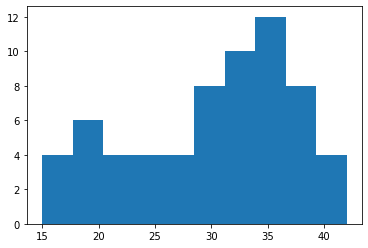

In [6]:
plt.hist(ligand_size_list)

## 3. Lipinski's rule of five

In [7]:
def n_ligand_fulfilled_criteria(path_json, criteria):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = (o for o in objects if o[criteria] == 1)
    
    return len(list(objects_filtered))

In [8]:
n_hba = n_ligand_fulfilled_criteria(PATH_COMBINATORIAL_LIBRARY, 'hba')
n_hbd = n_ligand_fulfilled_criteria(PATH_COMBINATORIAL_LIBRARY, 'hbd')
n_mwt = n_ligand_fulfilled_criteria(PATH_COMBINATORIAL_LIBRARY, 'mwt')
n_logp = n_ligand_fulfilled_criteria(PATH_COMBINATORIAL_LIBRARY, 'logp')

In [9]:
def n_ligand_fulfilled_lipinski(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')
        
    # filter objects
    objects_filtered = (o for o in objects if o['hba']+o['hbd']+o['mwt']+o['logp'] >= 3)

    return len(list(objects_filtered))

In [10]:
n_lipinski = n_ligand_fulfilled_lipinski(PATH_COMBINATORIAL_LIBRARY)

In [11]:
print(n_hba, n_hbd, n_mwt, n_logp, n_lipinski)

60 64 50 64 60


## 4. Original ligands

### Exact matches

In [12]:
def original_ligands_exact_matches(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = (o for o in objects if o['original_exact'] != [])
    objects_filtered_df = pd.DataFrame(objects_filtered)
    
    # sanity check: exact matches must also show up as substructures matches
    if any(objects_filtered_df.original_substructure.apply(len) == 0):
        raise ValueError(f'One or more ligands have an exact match but no substructure.')
    
    print(f'Number of exact matches in original ligands: {objects_filtered_df.shape[0]}')
    
    return objects_filtered_df

In [13]:
original_ligands_exact_matches(PATH_COMBINATORIAL_LIBRARY)

Number of exact matches in original ligands: 4


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[FP_7, GA_6], [SE_14, FP_8], [SE_13, AP_7]]","[FP_1, SE_2, GA_1, AP_2]",1,1,1,1,33,[],"[CHEMBL500021, 0.34]","[1, 8]","[1, 8]",InChI=1S/C23H28N8OS/c1-15-13-20(29-28-15)25-19...
1,"[[SE_13, AP_16], [FP_6, AP_17]]","[AP_4, SE_4, FP_2]",1,1,1,1,35,[],"[CHEMBL265282, 0.32]",[6],[6],InChI=1S/C26H28N6O3/c1-30-12-14-31(15-13-30)20...
2,"[[FP_7, GA_6], [SE_14, FP_8], [SE_13, AP_7]]","[FP_1, SE_2, GA_1, AP_2]",1,1,1,1,33,[],"[CHEMBL500021, 0.34]","[1, 8]","[1, 8]",InChI=1S/C23H28N8OS/c1-15-13-20(29-28-15)25-19...
3,"[[SE_13, AP_16], [FP_6, AP_17]]","[AP_4, SE_4, FP_2]",1,1,1,1,35,[],"[CHEMBL265282, 0.32]",[6],[6],InChI=1S/C26H28N6O3/c1-30-12-14-31(15-13-30)20...


### Substructure matches

In [14]:
def original_ligands_substructure_matches(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = (o for o in objects if o['original_substructure'] != [])
    objects_filtered_df = pd.DataFrame(objects_filtered)
    
    print(f'Number of ligands with substructures in original ligands: {objects_filtered_df.shape[0]}')
    
    return objects_filtered_df

In [15]:
original_ligands_substructure_matches(PATH_COMBINATORIAL_LIBRARY)

Number of ligands with substructures in original ligands: 6


,bond_ids,fragment_ids,hba,hbd,mwt,logp,n_atoms,chembl_exact,chembl_most_similar,original_exact,original_substructure,inchi
0,"[[SE_16, AP_9]]","[SE_3, AP_3]",1,1,1,1,24,[],"[CHEMBL405398, 0.33]",[],[9],InChI=1S/C15H20N6O2S/c1-11-17-13(19-15-16-9-12...
1,"[[FP_7, GA_6], [SE_14, FP_8], [SE_13, AP_7]]","[FP_1, SE_2, GA_1, AP_2]",1,1,1,1,33,[],"[CHEMBL500021, 0.34]","[1, 8]","[1, 8]",InChI=1S/C23H28N8OS/c1-15-13-20(29-28-15)25-19...
2,"[[SE_13, AP_16], [FP_6, AP_17]]","[AP_4, SE_4, FP_2]",1,1,1,1,35,[],"[CHEMBL265282, 0.32]",[6],[6],InChI=1S/C26H28N6O3/c1-30-12-14-31(15-13-30)20...
3,"[[SE_16, AP_9]]","[SE_3, AP_3]",1,1,1,1,24,[],"[CHEMBL405398, 0.33]",[],[9],InChI=1S/C15H20N6O2S/c1-11-17-13(19-15-16-9-12...
4,"[[FP_7, GA_6], [SE_14, FP_8], [SE_13, AP_7]]","[FP_1, SE_2, GA_1, AP_2]",1,1,1,1,33,[],"[CHEMBL500021, 0.34]","[1, 8]","[1, 8]",InChI=1S/C23H28N8OS/c1-15-13-20(29-28-15)25-19...
5,"[[SE_13, AP_16], [FP_6, AP_17]]","[AP_4, SE_4, FP_2]",1,1,1,1,35,[],"[CHEMBL265282, 0.32]",[6],[6],InChI=1S/C26H28N6O3/c1-30-12-14-31(15-13-30)20...


## 5. ChEMBL ligands

### Most similar ChEMBL ligands

In [16]:
def similarities_of_most_similar_chembl_ligands(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o['chembl_most_similar'][1] for o in objects]
    
    return objects_filtered

In [17]:
similarities = similarities_of_most_similar_chembl_ligands(PATH_COMBINATORIAL_LIBRARY)

(array([ 4.,  0.,  2., 10.,  0., 24.,  8., 10.,  0.,  6.]),
 array([0.22 , 0.238, 0.256, 0.274, 0.292, 0.31 , 0.328, 0.346, 0.364,
        0.382, 0.4  ]),
 <a list of 10 Patch objects>)

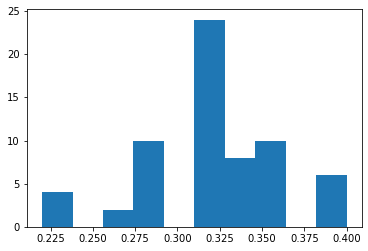

In [18]:
plt.hist(similarities)

### Exact matches

In [19]:
def exact_chembl_matches(path_json):

    # get object generator from json
    f = open(path_json, 'rb')
    objects = ijson.items(f, 'item')

    # filter objects
    objects_filtered = [o for o in objects if o['chembl_exact'] != []]
    objects_filtered_df = pd.DataFrame(objects_filtered)
    
    print(f'Number of exact matches in ChEMBL ligands: {objects_filtered_df.shape[0]}')
    
    return objects_filtered_df

In [20]:
exact_chembl_matches(PATH_COMBINATORIAL_LIBRARY)

Number of exact matches in ChEMBL ligands: 0


""
